In [ ]:
# Author: Yuki Rivera
# This notebook implements code for evaluating a basic transformer model built & trained in Keras

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Sets the file paths

In [ ]:
path = "/path/to/project/"
tokenizer_path = "basic_transformer_tokenizer.pkl"
model_path = "basic_transformer_model.keras"
perp_file_path = "basic_transformer_testing_perplexity.txt"

In [15]:
import sys
sys.path.insert(0, path)

### Imports basic transformer layer definitions from a separate python file

In [ ]:
from basic_transformer_layers import PositionalEncoding, EncoderBlock, DecoderBlock

### Imports other libraries

In [ ]:
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import random
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display
import matplotlib.pyplot as plt
import umap
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
import time

### Hyperparemeters used in training

In [ ]:
full_data = False
data_size = 500

# Max sequence length
enc_max_len = 64
dec_max_len = 150

vocab_limit = 40000

# Dimension for token embeddings
embed_dim = 128
# Number of attention heads
num_heads = 4
# Hidden layer size in the feed-forward network
ff_dim = 512
num_layers = 2          # Number of transformer blocks
dropout_rate = 0.1

# size of each head
key_dim = embed_dim // num_heads
# value to avoid zero division for normalization
eps = 1e-6

# early stopping patience
patience = 3

# batch_size
batch_size = 32
# number of epochs
num_epochs = 20
# validation_split
validation_ratio = 0.1

# learning rate
alpha = 1e-4 # for small data 3e-4

# top k
k_value = 20
# temperature
temp = 1.5


### Loads the tokenizer

In [18]:
with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)

### Loads the model

In [20]:
model = load_model(model_path,
    custom_objects={
        "EncoderBlock": EncoderBlock,
        "DecoderBlock": DecoderBlock,
        "PositionalEncoding": PositionalEncoding
    }
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'encoder_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'encoder_block_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'decoder_block', however the layer d

### Loads the test data

In [21]:
pd.set_option('display.max_colwidth', None)

In [ ]:
df = pd.read_csv("prompt_synopsis_test.csv")
testing_df = df.iloc[[20, 26, 64,84,88,98,106,111,127,164,190,199,225,231,242,244,259,298, 10597, 10609]]

In [26]:
prompts = testing_df["prompt"].tolist()
references = testing_df["synopsis"].tolist()
tags_list = testing_df['tags_combined'].tolist()

### Preprocess the data

In [27]:
# Cleans text
def clean_text(text):
    return text.lower().strip().replace('\n', ' ')

In [ ]:
for col in ['prompt', 'synopsis']:
    testing_df[col] = testing_df[col].astype(str).apply(clean_text)

# Gets special token IDs from the loaded Keras tokenizer's word_index.
PAD_ID = tokenizer.word_index.get("<PAD>", 0)
BOS_ID = tokenizer.word_index.get("<BOS>")
EOS_ID = tokenizer.word_index.get("<EOS>")

# Converts text to integer sequences.
test_prompt_seqs = tokenizer.texts_to_sequences(testing_df['prompt'].tolist())
test_synopsis_seqs = tokenizer.texts_to_sequences(testing_df['synopsis'].tolist())

# Creates the shifted input/target pairs for the decoder.
test_decoder_input_ids = [[BOS_ID] + seq for seq in test_synopsis_seqs]
test_decoder_target_ids = [seq + [EOS_ID] for seq in test_synopsis_seqs]

# Pads the sequences to a uniform length.
X_enc_test = pad_sequences(test_prompt_seqs, maxlen=enc_max_len, padding='post', value=PAD_ID)
X_dec_test = pad_sequences(test_decoder_input_ids, maxlen=dec_max_len, padding='post', value=PAD_ID)
y_test = pad_sequences(test_decoder_target_ids, maxlen=dec_max_len, padding='post', value=PAD_ID)

# Reshapes the final target data for the loss function.
y_test = np.expand_dims(y_test, axis=-1)

<ipython-input-28-647376479>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_df[col] = testing_df[col].astype(str).apply(clean_text)
<ipython-input-28-647376479>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_df[col] = testing_df[col].astype(str).apply(clean_text)


### Test perplexity calculation

In [ ]:
# Evaluates the model on the test set
test_loss, test_accuracy = model.evaluate(
    [X_enc_test, X_dec_test], y_test, verbose=0
)

# Calculates perplexity from the test loss
test_perplexity = np.exp(test_loss)

print(f"Final Transformer Test Perplexity: {test_perplexity:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'positional_encoding' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'positional_encoding_1' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Final Transformer Test Perplexity: 41.86


### Saves the perplexity to a text file

In [ ]:
with open(perp_file_path, 'w') as f:
    f.write(str(test_perplexity))

### Helper function to improve generation quality

In [ ]:
def top_k_sampling(logits, k=5, temperature=1.0):
    # Applies temperature
    logits = logits / temperature

    # Get top-k token indices and their probabilities
    top_k_indices = np.argpartition(logits, -k)[-k:]
    top_k_logits = logits[top_k_indices]
    top_k_probs = tf.nn.softmax(top_k_logits).numpy()

    # Samples from the top-k tokens
    sampled_index = np.random.choice(top_k_indices, p=top_k_probs)
    return sampled_index

### Helper function to prepare encoder inputs

In [ ]:
# Converts a batch of input into padded token ids for the encoder
def _prepare_encoder_inputs(tokenizer, batch_prompts, enc_max_len, pad_id):

    input_ids_batch_list = tokenizer.texts_to_sequences(batch_prompts)
    X_enc_batch = pad_sequences(input_ids_batch_list, maxlen=enc_max_len, padding='post', value=pad_id)

    X_enc_batch_tf = None 

    # converts to tensorflow tensor
    X_enc_batch_tf = tf.constant(X_enc_batch, dtype=tf.int32)

    return X_enc_batch_tf

### Function to convert generated ids to text

In [ ]:
# Converts a batch of generated token id sequences to readable text
def _decode_generated_ids_batched(final_generated_ids_tensor, tokenizer, tokenizer_special_ids):

    generated_texts_list = []
    # maps token ids back to words
    id_to_word = {v: k for k, v in tokenizer.word_index.items()}

    for i in range(tf.shape(final_generated_ids_tensor)[0]): 
        sequence_ids = final_generated_ids_tensor[i].numpy()

        # Finds the first EOS or PAD token to truncate the sequence
        true_end = next((j for j, x in enumerate(sequence_ids) if x == tokenizer_special_ids['EOS_ID'] or x == tokenizer_special_ids['PAD_ID']), len(sequence_ids))
        clean_sequence_ids = sequence_ids[:true_end]

        # Filters out special tokens and converts ids to words
        filtered_words = []
        for idx in clean_sequence_ids:
            if idx not in [tokenizer_special_ids['BOS_ID'], tokenizer_special_ids['EOS_ID'], tokenizer_special_ids['PAD_ID']]:
                filtered_words.append(id_to_word.get(idx, '<unk>'))

        # Joins tokens into a text string
        generated_texts_list.append(" ".join(filtered_words))
    return generated_texts_list

### Function to select the next token for each sequence in a batch 

In [ ]:
def _select_next_tokens_batched(next_logits_batch, is_generating, tokenizer_special_ids, k, temperature):

    # Ensures logits are float32 for TensorFlow operations
    next_logits_batch = tf.cast(next_logits_batch, dtype=tf.float32)

    # Applies temperature 
    next_logits_batch = next_logits_batch / temperature

    # Masks OOV token to prevent it from being sampled
    if tokenizer_special_ids['OOV_ID'] is not None:
        oov_id = tokenizer_special_ids['OOV_ID']
        batch_indices = tf.range(tf.shape(next_logits_batch)[0], dtype=tf.int32)
        oov_indices = tf.stack([batch_indices, tf.fill(tf.shape(batch_indices), oov_id)], axis=1)

        oov_values = tf.fill(tf.shape(batch_indices), -1e9) 

        # Updates the logits at the OOV index for all samples in the batch
        next_logits_batch = tf.tensor_scatter_nd_update(next_logits_batch, oov_indices, oov_values)

    # Applies top-k sampling
    if k > 1:
        # Gets top-k values and their original indices for each row in the batch
        top_k_values, top_k_indices = tf.math.top_k(next_logits_batch, k=k, sorted=False)

        # Reshape top_k_indices to (batch_size * k, 1) and combine with batch indices
        batch_indices_expanded = tf.repeat(tf.range(tf.shape(next_logits_batch)[0]), k)
        top_k_indices_flat = tf.reshape(top_k_indices, [-1]) 

        # Assigns top-k logits to their original positions in the output tensor
        scatter_indices = tf.stack([batch_indices_expanded, top_k_indices_flat], axis=1) 

        # Fills logits with -1e9 to mask everything, then inserts top-k values at their positions
        masked_logits = tf.fill(tf.shape(next_logits_batch), -1e9)
        next_logits_batch = tf.tensor_scatter_nd_update(masked_logits, scatter_indices, tf.reshape(top_k_values, [-1]))

    # Samples from the masked logits
    next_tokens = tf.random.categorical(next_logits_batch, num_samples=1, dtype=tf.int32)
    next_tokens = tf.squeeze(next_tokens, axis=1) 

    # Applies 'is_generating' mask
    next_tokens = tf.where(is_generating, next_tokens, tokenizer_special_ids['PAD_ID'])

    return next_tokens 

### Function to generate synopsis using batch process

In [ ]:
def generate_synopsis_transformer_batched(model: Model, tokenizer, batch_prompts: list, enc_max_len: int, dec_max_len: int, k: int = 5, temperature: float = 1.0):

    batch_size = len(batch_prompts)

    tokenizer_special_ids = {
        'PAD_ID': tokenizer.word_index.get("<PAD>", 0),
        'BOS_ID': tokenizer.word_index.get("<BOS>"),
        'EOS_ID': tokenizer.word_index.get("<EOS>"),
        'OOV_ID': tokenizer.word_index.get("<OOV>", None)
    }

    if tokenizer_special_ids['BOS_ID'] is None: raise ValueError("BOS_ID not found in tokenizer.word_index.")
    if tokenizer_special_ids['EOS_ID'] is None: raise ValueError("EOS_ID not found in tokenizer.word_index.")

    X_enc_batch_tf = _prepare_encoder_inputs(tokenizer, batch_prompts, enc_max_len, tokenizer_special_ids['PAD_ID'])

    decoder_input_batch = tf.constant(tokenizer_special_ids['BOS_ID'], shape=(batch_size, 1), dtype=tf.int32)
    generated_ids_ta = tf.TensorArray(tf.int32, size=dec_max_len, dynamic_size=False, clear_after_read=False)
    is_generating = tf.constant(True, shape=(batch_size,), dtype=tf.bool)

    for t in tf.range(dec_max_len):
        if not tf.reduce_any(is_generating):
            break
        
        # Gets the prediction
        preds = model.predict([X_enc_batch_tf, decoder_input_batch], verbose=0)

        # Extracts the logits for the last position in each sequence
        next_logits_batch = preds[:, tf.shape(decoder_input_batch)[1] - 1, :]

        # Selects next tokens for the batch using sampling
        next_tokens_batch = _select_next_tokens_batched(next_logits_batch, is_generating, tokenizer_special_ids, k, temperature)

        generated_ids_ta = generated_ids_ta.write(t, next_tokens_batch)

        # Updates 'is_generating' status for the next step
        is_eos_this_step = tf.equal(next_tokens_batch, tokenizer_special_ids['EOS_ID'])
        is_generating = is_generating & tf.logical_not(is_eos_this_step)

        # Appends new tokens to decoder_input for the next iteration
        next_tokens_reshaped = tf.expand_dims(next_tokens_batch, axis=1)
        decoder_input_batch = tf.concat([decoder_input_batch, next_tokens_reshaped], axis=1)

    final_generated_ids_tensor = tf.transpose(generated_ids_ta.stack())
    generated_texts_list = _decode_generated_ids_batched(final_generated_ids_tensor, tokenizer, tokenizer_special_ids)


    return generated_texts_list


### Function to get generated output and calculates cosine similarity

In [ ]:
def evaluate_outputs(model, tokenizer, prompts, references, tags_combined, enc_max_len, dec_max_len, print_count=10, batch_size=32, k=5, temperature=1.0):

    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
    results = []

    for i in tqdm(range(0, len(prompts), batch_size), desc="Evaluating Batches"):

        batch_prompts = prompts[i:i+batch_size]
        batch_true_synopses = references[i:i+batch_size]
        batch_tags = tags_combined[i:i+batch_size]

        # Processes text generation in batches
        batch_generated_synopses = generate_synopsis_transformer_batched(
            model, tokenizer, batch_prompts, enc_max_len, dec_max_len,
            k=k, temperature=temperature
        )

        emb_tags_batch = embedding_model.encode(batch_tags, batch_size=batch_size, show_progress_bar=False)
        emb_generated_batch = embedding_model.encode(batch_generated_synopses, batch_size=batch_size, show_progress_bar=False)

        similarities_batch = cosine_similarity(emb_generated_batch, emb_tags_batch).diagonal()

        for j in range(len(batch_prompts)):
            current_prompt = batch_prompts[j]
            current_true_synopsis = batch_true_synopses[j]
            current_tags = batch_tags[j]
            current_generated_synopsis = batch_generated_synopses[j]
            current_similarity = similarities_batch[j]

            results.append({
                "tags_combined": current_tags,
                "prompt": current_prompt,
                "generated": current_generated_synopsis,
                "true_synopsis": current_true_synopsis,
                "cosine_similarity": current_similarity
            })

            if i + j < print_count:
                print(f"\nPrompt {i + j + 1}: {current_prompt}")
                print(f"Generated: {current_generated_synopsis}")
                print(f"True Synopsis: {current_true_synopsis}")
                print(f"Cosine Similarity: {current_similarity:.3f}")
                print("—" * 50)

    return results

### Gets the generated output and cosine similarity

In [41]:
similarity_results = evaluate_outputs(
    model,
    tokenizer,
    prompts,
    references,
    tags_list,
    enc_max_len,
    dec_max_len,
    print_count=10,
    batch_size=32,
    k=k_value,
    temperature=temp
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Evaluating Batches:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'positional_encoding' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'positional_encoding_1' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
Evaluating Batches: 100%|██████████| 1/1 [16:58<00:00, 1018.70s/it]


Prompt 1: Write an anime synopsis that matches 'Adventure, Comedy and Fantasy'.
Generated: one drama adaptation and friends but as they are attacked their life after she loves and is called its past on their home that takes one time at various danger. she is called in japan. but this is sent off the most other world of these monsters. this student in an accident he encounters her way when no young student from another of his friends the world. when that can make what the most team finds it, a strange team can only one night the two find her family to get the power they were already taken his powers as an adventure to discover how she meets the help his friend decides his best friends in search the first time from justice which will stop this battle from being in their past begin its new world. and is now no other world, will get him his own. she are the
True Synopsis: on one noteworthy day in the adventurer's guild, kazuma satou encounters someone unexpecteda fan of his named ran. sur

### Calculates the avg cosine similarity and saves to a text file

In [ ]:
avg_similarity = sum(r["cosine_similarity"] for r in similarity_results) / len(similarity_results)

In [ ]:
with open('avg_sim_transformer.txt', 'w') as f:
    f.write(str(avg_similarity))

### Saves all the results to a csv file

In [46]:
df_results = pd.DataFrame(similarity_results)
df_results.to_csv("generated_results_with_similarity.csv", index=False)

### Creates a table for easy check

In [47]:
# shows full text in cells
pd.set_option('display.max_colwidth', None)

# displays a table nicely

df_results.head(10).style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'left')]
}])

,tags_combined,prompt,generated,true_synopsis,cosine_similarity
0,adventure comedy fantasy,"Write an anime synopsis that matches 'Adventure, Comedy and Fantasy'.","one drama adaptation and friends but as they are attacked their life after she loves and is called its past on their home that takes one time at various danger. she is called in japan. but this is sent off the most other world of these monsters. this student in an accident he encounters her way when no young student from another of his friends the world. when that can make what the most team finds it, a strange team can only one night the two find her family to get the power they were already taken his powers as an adventure to discover how she meets the help his friend decides his best friends in search the first time from justice which will stop this battle from being in their past begin its new world. and is now no other world, will get him his own. she are the","on one noteworthy day in the adventurer's guild, kazuma satou encounters someone unexpecteda fan of his named ran. surprised that he even has a fan, kazuma attempts to play it cool to impress her. unfortunately for him, the guild's receptionist arrives with a request to defeat a giant golem guarding some ancient ruins, and kazuma accepts only to keep ran's admiration. upon kazuma and his party's successful return from the ruins, kazuma continues to shamelessly brag to ran. capitalizing on his desperation, the receptionist approaches him with another quest that requires him to return to the same ruins. hoping to find valuable treasures, kazuma once again convinces his party to join himbut this time, he may be biting off more than he can chew.",0.397459
1,mystery supernatural,Write an anime synopsis that matches 'Mystery and Supernatural'.,the fifth anime released the fourth years after episode volume.,"the anime is set in the fictional geso ward in tokyo, a school city where an app called aicis is becoming popular. those who get the app are given supernatural powers, which they use to pursue their own selfish desires, leading to many occurrences of violence and other incidents. the story focuses on a group of detectives who solve cases related to power wielders.",0.156352
2,historical mythology shoujo,Generate a 'Historical and Mythology' themed anime targeting 'Shoujo'.,"an extra recap episodes episode by no demons against its power which were born,","in the nineteenth century, we find lydia carlton living in scotland, making a living as a fairy doctor. she is one of those rare humans who can see and communicate with fairies. but no one believes her. however, edgar is in need of someone with a vast knowledge of fairy lore, and lydia is just that person. after rescuing her, he becomes her employer, but there are many secrets and emotions that seem to follow edgar, who claims to be the blue knight's earl.",0.232457
3,adventure,Write an anime synopsis that matches 'Adventure'.,"unaired episodes that bundled at japan included between episode the episode bluray releases. with its new character and it tells of becoming another new days at their powers for being attacked episodes on space. who must protect them. meanwhile, he will become new high her best of this version featuring dr. warriors but however, this girl that are not as this new characters where he finds its world behind her mother to become new high new years ago. the people set in an old girls where and no events where the other group takes the only more world, the new world. although his first encounter in all sorts for their past that have just just is on new time who would not find what can discover and take out about its time with this man is also in addition he decides in japan. in love the help it seems in","takashi loves reading books and especially loves alice's adventures in wonderland. one day, he buys some used books, and he finds one book thrown in. when takashi opens the book, the god of math m1 appeared. takashi is told that alice is

### Visualizing Tags VS Output Embeddings Scatter Plot Using UMAP

In [ ]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [49]:
sample_size = 100

In [50]:
# Check if the list has enough elements to sample from
if len(similarity_results) > sample_size:
    # Randomly sample 'sample_size' dictionaries from the similarity_results list
    sampled_results_for_plot = random.sample(similarity_results, sample_size)
else:
    # If there are fewer than 'sample_size' results, use all of them
    sampled_results_for_plot = similarity_results

tags_to_match = [row["tags_combined"] for row in sampled_results_for_plot]
generated_outputs = [row["generated"] for row in sampled_results_for_plot]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


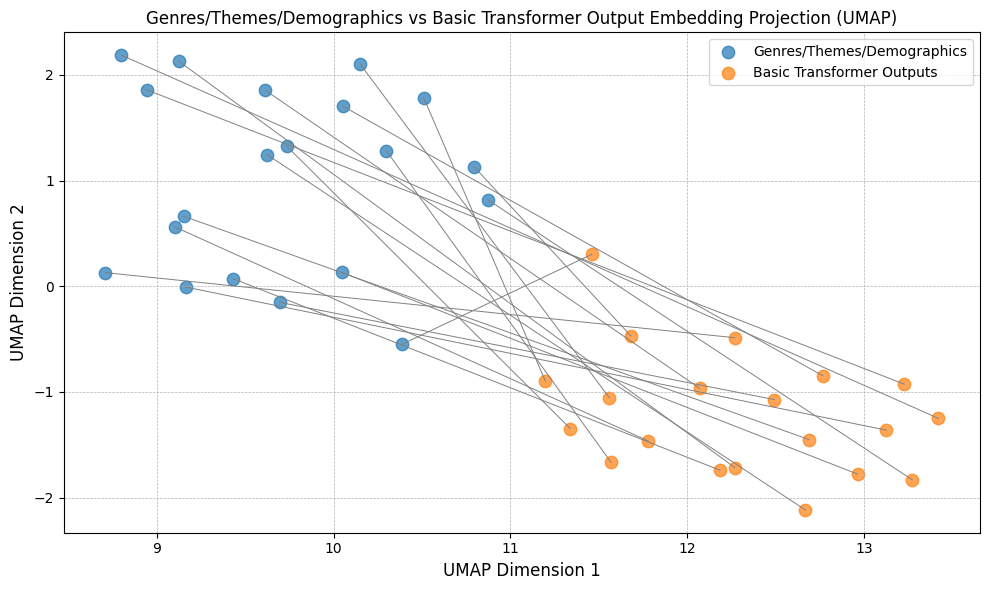

In [ ]:
# converts each tags and generated output into a high-dim vector
tags_embeddings = embedding_model.encode(tags_to_match)
output_embeddings = embedding_model.encode(generated_outputs)

# combines both embeddings into a single array
all_embeddings = np.vstack([tags_embeddings, output_embeddings])

# reduces the dimension for visualization
reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = reducer.fit_transform(all_embeddings)

# splits embeddings into the tags and the output
n = len(tags_to_match)
umap_tags = umap_embeddings[:n]
umap_outputs = umap_embeddings[n:]

# plots a scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(umap_tags[:, 0], umap_tags[:, 1], label="Genres/Themes/Demographics", alpha=0.7, s=80)
plt.scatter(umap_outputs[:, 0], umap_outputs[:, 1], label="Basic Transformer Outputs", alpha=0.7, s=80)

# draws light gray lines to show the differences between the tags vs output
for i in range(n):
    plt.plot([umap_tags[i, 0], umap_outputs[i, 0]],
             [umap_tags[i, 1], umap_outputs[i, 1]],
             c='gray', linewidth=0.7)

plt.title("Genres/Themes/Demographics vs Basic Transformer Output Embedding Projection (UMAP)")
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.savefig(
    'scatter_plot_transformer.png',
    dpi=300,
    bbox_inches='tight' 
)
plt.show()